In [2]:
import netCDF4 as nc
import xarray as xr

from pykrige.ok import OrdinaryKriging
from scipy.spatial import cKDTree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import matplotlib.colors as mcolors
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random

# Practice Dataset

In [3]:
sif_ds = nc.Dataset('oco2_LtSIF_20140914.nc4', 'r')

In [3]:
print(sif_ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    References: ['Sun, Y. et al., Remote Sensing of Environment (2018), https://doi.org/10.1016/j.rse.2018.02.016', 'Taylor, T.E. et al., Atmospheric Measurement Techniques (2016), https://doi.org/10.5194/amt-9-973-2016']
    conventions: CF-1.6
    product_version: B11012Ar
    summary: Fraunhofer-line based SIF retrievals
    keywords: ISS, OCO-2, Solar Induced Fluorescence, SIF
    keywords_vocabulary: NASA Global Change Master Directory (GCMD)
    cdm_data: point
    comment: These data were produced at JPL/Caltech
    date_created: 2023-03-29T21:47:56Z
    author_name: Jet Propulsion Laboratory/Caltech, Christian Frankenberg
    author_email: Christian.Frankenberg@jpl.nasa.gov
    secondary_author_name: Jet Propulsion Laboratory/Caltech, thomas kurosu
    secondary_author_email: thomas.kurosu@jpl.nasa.gov
    project: OCO-2 NASA/JPL
    geospatial_lat_min: -90
    geospatial_lat_max: 90
    geosp

In [4]:
print(sif_ds.variables.keys()) 

dict_keys(['Delta_Time', 'SZA', 'VZA', 'SAz', 'VAz', 'Longitude', 'Latitude', 'Longitude_Corners', 'Latitude_Corners', 'SIF_740nm', 'SIF_Uncertainty_740nm', 'Daily_SIF_740nm', 'Daily_SIF_757nm', 'Daily_SIF_771nm', 'Quality_Flag'])


In [4]:
# Centres for sites from fluxnet
centres = np.array([
    [6.4471, 50.8659],
    [133.6400, -22.2870],
    [-52.9249, 5.2788],
    [-121.6470, 38.1152],
    [-90.2723, 45.9459],
    [-2.6942, 5.2685],
    [-110.8660, 31.8214],
    [8.4104, 47.2102],
    [13.5881, 41.8494],
    [-90.0799, 45.8059],
    [140.5891, -34.0021],
    [-109.9420, 31.7365],
    [11.3275, 47.8064],
    [-110.0520, 31.7438],
    [8.1517, 40.6062]
])

In [20]:
# Practice kriging

block_size = 20

# Store results
all_results = []

start = time.time()
sif_long = sif_ds.variables['Longitude'][:]  # Longitude values
sif_lat = sif_ds.variables['Latitude'][:]  # Latitude values
sif_740nm = sif_ds.variables['Daily_SIF_740nm'][:]  # SIF 740nm values
sif_757nm = sif_ds.variables['Daily_SIF_757nm'][:]  # SIF 757nm values
sif_771nm = sif_ds.variables['Daily_SIF_771nm'][:]  # SIF 771nm values
sif_qual = sif_ds.variables['Quality_Flag'][:]  # Quality Flag values

# Flatten to 1D arrays
sif_long = sif_long.flatten()
sif_lat = sif_lat.flatten()
sif_740nm = sif_740nm.flatten()
sif_757nm = sif_757nm.flatten()
sif_771nm = sif_771nm.flatten()
sif_qual = sif_qual.flatten()

# Create a DataFrame
oco = pd.DataFrame({
    'Latitude': sif_lat,
    'Longitude': sif_long,
    'SIF_740': sif_740nm,
    'SIF_757': sif_757nm,
    'SIF_771': sif_771nm,
    'SIF_Quality': sif_qual,
})

# Remove entries with quality flag of 2
oco = oco[oco['SIF_Quality'] != 2]

for centre in centres:
    loop_start = time.time()
    # Define the block boundaries
    min_lon, max_lon = centre[0] - block_size, centre[0] + block_size
    min_lat, max_lat = centre[1] - (block_size / 2), centre[1] + (block_size / 2)

    # Subset the data for SIF 740nm
    mask = (oco['Longitude'] >= min_lon) & (oco['Longitude'] <= max_lon) & \
           (oco['Latitude'] >= min_lat) & (oco['Latitude'] <= max_lat)
    block_data = oco[mask]

    if block_data.empty:
        print(f'Centre: {centre} empty')
        continue 

    # Apply Ordinary Kriging for SIF 740nm
    kriging_model_740 = OrdinaryKriging(
        block_data['Longitude'],
        block_data['Latitude'],
        block_data['SIF_740'],
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )
    predicted_740, ss_740 = kriging_model_740.execute('points', [centre[0]], [centre[1]])

    # Apply Ordinary Kriging for SIF 757nm
    kriging_model_757 = OrdinaryKriging(
        block_data['Longitude'],
        block_data['Latitude'],
        block_data['SIF_757'],
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )
    predicted_757, ss_757 = kriging_model_757.execute('points', [centre[0]], [centre[1]])

    # Apply Ordinary Kriging for SIF 771nm
    kriging_model_771 = OrdinaryKriging(
        block_data['Longitude'],
        block_data['Latitude'],
        block_data['SIF_771'],
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )
    predicted_771, ss_771 = kriging_model_771.execute('points', [centre[0]], [centre[1]])

    loop_end = time.time()
    loop_time = loop_end - loop_start

    all_results.append({
        'Longitude': centre[0],
        'Latitude': centre[1],
        'SIF_740_Prediction': round(predicted_740[0], 4),
        'SIF_740_Error': round(ss_740[0], 4),
        'SIF_757_Prediction': round(predicted_757[0], 4),
        'SIF_757_Error': round(ss_757[0], 4),
        'SIF_771_Prediction': round(predicted_771[0], 4),
        'SIF_771_Error': round(ss_771[0], 4),
        'Time': round(loop_time, 2)
    })
    print(f"Estimated SIF at {centre}: SIF_740={round(predicted_740[0], 2)}, SIF_757={round(predicted_757[0], 2)}, SIF_771={round(predicted_771[0], 2)} with errors {round(ss_740[0], 4)}, {round(ss_757[0], 4)}, {round(ss_771[0], 4)}./nTime Taken: {round(loop_time, 2)} seconds.")
    
end = time.time()
time_taken = end - start
print(f'Overall time taken: {round(time_taken,2)} seconds')

Estimated SIF at [ 6.4471 50.8659]: SIF_740=0.27, SIF_757=0.16, SIF_771=0.14 with errors 0.0477, 0.0277, 0.0166 respectively. Time Taken: 25.91 seconds.
Estimated SIF at [133.64  -22.287]: SIF_740=0.07, SIF_757=0.04, SIF_771=0.03 with errors 0.026, 0.0196, 0.0105 respectively. Time Taken: 119.76 seconds.
Estimated SIF at [-52.9249   5.2788]: SIF_740=0.47, SIF_757=0.3, SIF_771=0.22 with errors 0.1082, 0.056, 0.0372 respectively. Time Taken: 13.6 seconds.
Estimated SIF at [-121.647    38.1152]: SIF_740=0.05, SIF_757=0.08, SIF_771=0.0 with errors 0.0551, 0.063, 0.0195 respectively. Time Taken: 0.87 seconds.
Estimated SIF at [-90.2723  45.9459]: SIF_740=0.37, SIF_757=0.23, SIF_771=0.17 with errors 0.1161, 0.0537, 0.0376 respectively. Time Taken: 14.98 seconds.
Estimated SIF at [-2.6942  5.2685]: SIF_740=0.35, SIF_757=0.25, SIF_771=0.15 with errors 0.1074, 0.0596, 0.0349 respectively. Time Taken: 26.07 seconds.
Estimated SIF at [-110.866    31.8214]: SIF_740=0.1, SIF_757=0.07, SIF_771=0.04 

In [5]:
sif_long_list = sif_long.tolist()
sif_lat_list = sif_lat.tolist()
sif_740nm_list = sif_740nm.tolist()
sif_757nm_list = sif_757nm.tolist()
sif_771nm_list = sif_771nm.tolist()

NameError: name 'sif_long' is not defined

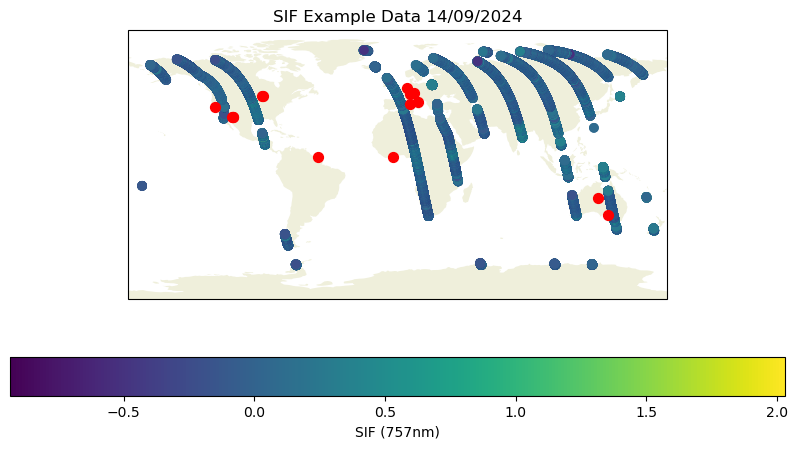

In [9]:
# Plot of centres against SIF data on given day

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()  # Optionally set a global view (adjust as needed)

# Add natural earth features
ax.add_feature(cfeature.LAND)  # Add land
#ax.add_feature(cfeature.COASTLINE)  # Add coastlines
#ax.add_feature(cfeature.BORDERS, linestyle = ':')  # Add country borders

# Define a colormap and a normalization based on the entire dataset
global_min = np.min(sif_757nm)
global_max = np.max(sif_757nm)
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

# Scatter plot for the recorded data
sc = ax.scatter(sif_long_list, sif_lat_list, c=sif_757nm_list, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Sites centre points
centre_lons = centres[:, 0]
centre_lats = centres[:, 1]
ax.scatter(centre_lons, centre_lats, color='red', s=50, transform=ccrs.PlateCarree(), label='Sites')

# Add a colorbar with the normalization based on the entire dataset
cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label='SIF (757nm)')
cbar.set_label('SIF (757nm)', rotation=0)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('SIF Example Data 14/09/2024')

plt.show()

# Importing and Krigging

In [12]:
dates = [
    '20140906', '20140907', '20140914', '20140917', '20140918', 
    '20140919', '20140921', '20140923', '20140925', '20141010',
    '20141011', '20141017', '20141018', '20141028', '20141031',
    '20141103', '20141105', '20141108', '20141212', '20141221',
    '20141222', '20141223', '20141226', '20141228', '20141230',
]

In [13]:
centres = np.array([
    [6.4471, 50.8659],
    [133.6400, -22.2870],
    [-52.9249, 5.2788],
    [-121.6470, 38.1152],
    [-90.2723, 45.9459],
    [-2.6942, 5.2685],
    [-110.8660, 31.8214],
    [8.4104, 47.2102],
    [13.5881, 41.8494],
    [-90.0799, 45.8059],
    [140.5891, -34.0021],
    [-109.9420, 31.7365],
    [11.3275, 47.8064],
    [-110.0520, 31.7438],
    [8.1517, 40.6062]
])

In [15]:
# Prints success and failures so failures can be redone with increased block

block_size = 20

# Store results
all_results = []
empty_blocks = []

start = time.time()
for date in dates:
    file_path = f'oco2_LtSIF_{date}.nc4'

    sif_ds = nc.Dataset(file_path, 'r')
    sif_long = sif_ds.variables['Longitude'][:]  
    sif_lat = sif_ds.variables['Latitude'][:]  
    sif_740nm = sif_ds.variables['Daily_SIF_740nm'][:]  
    sif_757nm = sif_ds.variables['Daily_SIF_757nm'][:]  
    sif_771nm = sif_ds.variables['Daily_SIF_771nm'][:]  
    sif_qual = sif_ds.variables['Quality_Flag'][:]  

    sif_long = sif_long.flatten()
    sif_lat = sif_lat.flatten()
    sif_740nm = sif_740nm.flatten()
    sif_757nm = sif_757nm.flatten()
    sif_771nm = sif_771nm.flatten()
    sif_qual = sif_qual.flatten()

    oco = pd.DataFrame({
        'Latitude': sif_lat,
        'Longitude': sif_long,
        'SIF_740': sif_740nm,
        'SIF_757': sif_757nm,
        'SIF_771': sif_771nm,
        'SIF_Quality': sif_qual,
    })

    oco = oco[oco['SIF_Quality'] != 2]

    date_start = time.time()
    for centre in centres:
        loop_start = time.time()
        min_lon, max_lon = centre[0] - block_size, centre[0] + block_size
        min_lat, max_lat = centre[1] - (block_size / 2), centre[1] + (block_size / 2)

        # Subset the data for SIF 740nm
        mask = (oco['Longitude'] >= min_lon) & (oco['Longitude'] <= max_lon) & \
               (oco['Latitude'] >= min_lat) & (oco['Latitude'] <= max_lat)
        block_data = oco[mask]
        
        # Appending empty blocks to dictionary
        if block_data.empty:
            print(f'Centre: {centre} empty on date: {date}')
            empty_blocks.append({
                'Date': date,
                'Longitude': centre[0],
                'Latitude': centre[1],    
            })
            continue  # Skip this block

        # Apply Ordinary Kriging for SIF 740nm
        kriging_model_740 = OrdinaryKriging(
            block_data['Longitude'],
            block_data['Latitude'],
            block_data['SIF_740'],
            variogram_model='spherical',
            verbose=False,
            enable_plotting=False
        )
        predicted_740, ss_740 = kriging_model_740.execute('points', [centre[0]], [centre[1]])

        # Apply Ordinary Kriging for SIF 757nm
        kriging_model_757 = OrdinaryKriging(
            block_data['Longitude'],
            block_data['Latitude'],
            block_data['SIF_757'],
            variogram_model='spherical',
            verbose=False,
            enable_plotting=False
        )
        predicted_757, ss_757 = kriging_model_757.execute('points', [centre[0]], [centre[1]])

        # Apply Ordinary Kriging for SIF 771nm
        kriging_model_771 = OrdinaryKriging(
            block_data['Longitude'],
            block_data['Latitude'],
            block_data['SIF_771'],
            variogram_model='spherical',
            verbose=False,
            enable_plotting=False
        )
        predicted_771, ss_771 = kriging_model_771.execute('points', [centre[0]], [centre[1]])

        loop_end = time.time()
        loop_time = loop_end - loop_start

        all_results.append({
            'Date': date,
            'Longitude': centre[0],
            'Latitude': centre[1],
            'SIF_740_Prediction': round(predicted_740[0], 4),
            'SIF_740_Error': round(ss_740[0], 4),
            'SIF_757_Prediction': round(predicted_757[0], 4),
            'SIF_757_Error': round(ss_757[0], 4),
            'SIF_771_Prediction': round(predicted_771[0], 4),
            'SIF_771_Error': round(ss_771[0], 4),
            'Time': round(loop_time, 2)
        })
        #print(f"Estimated SIF at {centre} on {date}: SIF_740={round(predicted_740[0], 2)}, SIF_757={round(predicted_757[0], 2)}, SIF_771={round(predicted_771[0], 2)} with errors {round(ss_740[0], 4)}, {round(ss_757[0], 4)}, {round(ss_771[0], 4)} respectively. Time Taken: {round(loop_time, 2)} seconds.")
    
    date_end = time.time()
    date_time = date_end - date_start
    print(f'{date} complete. Time taken: {round(date_time, 2)} seconds')

end = time.time()
time_taken = end - start
print(f'Overall time taken: {round(time_taken,2)} seconds')

20140906 complete. Time taken: 140.43 seconds
20140907 complete. Time taken: 632.24 seconds
Centre: [-52.9249   5.2788] empty on date: 20140914
20140914 complete. Time taken: 1307.67 seconds
20140917 complete. Time taken: 490.15 seconds
20140918 complete. Time taken: 509.8 seconds
20140919 complete. Time taken: 1547.83 seconds
20140921 complete. Time taken: 1412.99 seconds
20140923 complete. Time taken: 798.74 seconds
20140925 complete. Time taken: 378.68 seconds
20141010 complete. Time taken: 483.38 seconds
20141011 complete. Time taken: 386.07 seconds
20141017 complete. Time taken: 328.86 seconds
20141018 complete. Time taken: 2050.81 seconds
Centre: [ 6.4471 50.8659] empty on date: 20141028
Centre: [133.64  -22.287] empty on date: 20141028
Centre: [-2.6942  5.2685] empty on date: 20141028
Centre: [ 8.4104 47.2102] empty on date: 20141028
Centre: [13.5881 41.8494] empty on date: 20141028
Centre: [140.5891 -34.0021] empty on date: 20141028
Centre: [11.3275 47.8064] empty on date: 2014

In [21]:
results_df = pd.DataFrame(all_results)
results_df.head(5)

,Date,Longitude,Latitude,SIF_740_Prediction,SIF_740_Error,SIF_757_Prediction,SIF_757_Error,SIF_771_Prediction,SIF_771_Error,Time
0,20140906,6.4471,50.8659,0.2679,0.0477,0.1609,0.0277,0.1377,0.0166,8.67
1,20140906,133.6400,-22.2870,0.0702,0.0260,0.0368,0.0196,0.0297,0.0105,43.06
2,20140906,-52.9249,5.2788,0.4722,0.1082,0.3017,0.0560,0.2232,0.0372,4.63
3,20140906,-121.6470,38.1152,0.0507,0.0551,0.0830,0.0630,0.0003,0.0195,0.40
4,20140906,-90.2723,45.9459,0.3660,0.1161,0.2271,0.0537,0.1671,0.0376,5.66


In [18]:
results_df.to_excel('SIF_before_empties.xlsx')

In [14]:
empty_blocks_df = pd.DataFrame(empty_blocks)
empty_blocks_df

NameError: name 'empty_blocks' is not defined

# Sorting Missing Site/Dates

Redoing any sites that did not have enough close by data

In [3]:
centre_0914 = [-52.9249, 5.2788]
date = '20140914'
block_size = 60

start = time.time()
empty_results = []
sif_ds = nc.Dataset('oco2_LtSIF_20140914.nc4', 'r')

sif_long = sif_ds.variables['Longitude'][:]  # Longitude values
sif_lat = sif_ds.variables['Latitude'][:]  # Latitude values
sif_740nm = sif_ds.variables['Daily_SIF_740nm'][:]  # SIF 740nm values
sif_757nm = sif_ds.variables['Daily_SIF_757nm'][:]  # SIF 757nm values
sif_771nm = sif_ds.variables['Daily_SIF_771nm'][:]  # SIF 771nm values
sif_qual = sif_ds.variables['Quality_Flag'][:]  # Quality Flag values

# Flatten to 1D arrays
sif_long = sif_long.flatten()
sif_lat = sif_lat.flatten()
sif_740nm = sif_740nm.flatten()
sif_757nm = sif_757nm.flatten()
sif_771nm = sif_771nm.flatten()
sif_qual = sif_qual.flatten()

# Create a DataFrame
oco = pd.DataFrame({
    'Latitude': sif_lat,
    'Longitude': sif_long,
    'SIF_740': sif_740nm,
    'SIF_757': sif_757nm,
    'SIF_771': sif_771nm,
    'SIF_Quality': sif_qual,
})

# Remove entries with quality flag of 2
oco = oco[oco['SIF_Quality'] != 2]

loop_start = time.time()
min_lon, max_lon = centre_0914[0] - block_size, centre_0914[0] + block_size
min_lat, max_lat = centre_0914[1] - (block_size / 2), centre_0914[1] + (block_size / 2)

# Subset the data for SIF 740nm
mask = (oco['Longitude'] >= min_lon) & (oco['Longitude'] <= max_lon) & \
        (oco['Latitude'] >= min_lat) & (oco['Latitude'] <= max_lat)
block_data = oco[mask]
        
# Appending empty block to dictionary
if block_data.empty:
    print(f'Centre: {centre_0914} empty on date: {date}')

# Apply Ordinary Kriging for SIF 740nm
kriging_model_740 = OrdinaryKriging(
    block_data['Longitude'],
    block_data['Latitude'],
    block_data['SIF_740'],
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False
)
predicted_740, ss_740 = kriging_model_740.execute('points', [centre_0914[0]], [centre_0914[1]])

# Apply Ordinary Kriging for SIF 757nm
kriging_model_757 = OrdinaryKriging(
    block_data['Longitude'],
    block_data['Latitude'],
    block_data['SIF_757'],
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False
)
predicted_757, ss_757 = kriging_model_757.execute('points', [centre_0914[0]], [centre_0914[1]])

# Apply Ordinary Kriging for SIF 771nm
kriging_model_771 = OrdinaryKriging(
    block_data['Longitude'],
    block_data['Latitude'],
    block_data['SIF_771'],
    variogram_model='spherical',
    verbose=False,
    enable_plotting=False
)
predicted_771, ss_771 = kriging_model_771.execute('points', [centre_0914[0]], [centre_0914[1]])

loop_end = time.time()
loop_time = loop_end - loop_start

empty_results.append({
    'Date': date,
    'Longitude': centre_0914[0],
    'Latitude': centre_0914[1],
    'SIF_740_Prediction': round(predicted_740[0], 4),
    'SIF_740_Error': round(ss_740[0], 4),
    'SIF_757_Prediction': round(predicted_757[0], 4),
    'SIF_757_Error': round(ss_757[0], 4),
    'SIF_771_Prediction': round(predicted_771[0], 4),
    'SIF_771_Error': round(ss_771[0], 4),
    'Time': round(loop_time, 2)
})
#print(f"Estimated SIF at {centre} on {date}: SIF_740={round(predicted_740[0], 2)}, SIF_757={round(predicted_757[0], 2)}, SIF_771={round(predicted_771[0], 2)} with errors {round(ss_740[0], 4)}, {round(ss_757[0], 4)}, {round(ss_771[0], 4)} respectively. Time Taken: {round(loop_time, 2)} seconds.")
    

end = time.time()
time_taken = end - start
print(f'Overall time taken: {round(time_taken,2)} seconds')

Overall time taken: 129.91 seconds


In [5]:
centres_1028 = np.array([[6.4471, 50.8659],[133.6400, -22.2870],[-2.6942, 5.2685],[8.4104, 47.2102],
                        [13.5881, 41.8494], [140.5891, -34.0021], [11.3275, 47.8064], [8.1517, 40.6062]])
date = '20141028'

# Initial block size
initial_block_size = 80
max_block_size = 180  # Define the maximum block size you are willing to use

sif_ds = nc.Dataset('oco2_LtSIF_20141028.nc4', 'r')

sif_long = sif_ds.variables['Longitude'][:]  # Longitude values
sif_lat = sif_ds.variables['Latitude'][:]  # Latitude values
sif_740nm = sif_ds.variables['Daily_SIF_740nm'][:]  # SIF 740nm values
sif_757nm = sif_ds.variables['Daily_SIF_757nm'][:]  # SIF 757nm values
sif_771nm = sif_ds.variables['Daily_SIF_771nm'][:]  # SIF 771nm values
sif_qual = sif_ds.variables['Quality_Flag'][:]  # Quality Flag values

# Flatten to 1D arrays
sif_long = sif_long.flatten()
sif_lat = sif_lat.flatten()
sif_740nm = sif_740nm.flatten()
sif_757nm = sif_757nm.flatten()
sif_771nm = sif_771nm.flatten()
sif_qual = sif_qual.flatten()

# Create a DataFrame
oco = pd.DataFrame({
    'Latitude': sif_lat,
    'Longitude': sif_long,
    'SIF_740': sif_740nm,
    'SIF_757': sif_757nm,
    'SIF_771': sif_771nm,
    'SIF_Quality': sif_qual,
})

# Remove entries with quality flag of 2
oco = oco[oco['SIF_Quality'] != 2]

date_start = time.time()

for centre in centres_1028:
    loop_start = time.time()
    block_size = initial_block_size
    found_data = False

    while block_size <= max_block_size and not found_data:
        # Define the block boundaries
        min_lon, max_lon = centre[0] - block_size, centre[0] + block_size
        min_lat, max_lat = centre[1] - (block_size / 2), centre[1] + (block_size / 2)

        # Subset the data for SIF prediction
        mask = (oco['Longitude'] >= min_lon) & (oco['Longitude'] <= max_lon) & \
               (oco['Latitude'] >= min_lat) & (oco['Latitude'] <= max_lat)
        block_data = oco[mask]

        if block_data.empty:
            print(f'Centre: {centre} empty on date: {date} with block size: {block_size}')
            block_size += 10  # Increase block size
        else:
            found_data = True
            # Apply Ordinary Kriging for SIF 740nm
            kriging_model_740 = OrdinaryKriging(
                block_data['Longitude'],
                block_data['Latitude'],
                block_data['SIF_740'],
                variogram_model='spherical',
                verbose=False,
                enable_plotting=False
            )
            predicted_740, ss_740 = kriging_model_740.execute('points', [centre[0]], [centre[1]])

            # Apply Ordinary Kriging for SIF 757nm
            kriging_model_757 = OrdinaryKriging(
                block_data['Longitude'],
                block_data['Latitude'],
                block_data['SIF_757'],
                variogram_model='spherical',
                verbose=False,
                enable_plotting=False
            )
            predicted_757, ss_757 = kriging_model_757.execute('points', [centre[0]], [centre[1]])

            # Apply Ordinary Kriging for SIF 771nm
            kriging_model_771 = OrdinaryKriging(
                block_data['Longitude'],
                block_data['Latitude'],
                block_data['SIF_771'],
                variogram_model='spherical',
                verbose=False,
                enable_plotting=False
            )
            predicted_771, ss_771 = kriging_model_771.execute('points', [centre[0]], [centre[1]])

            loop_end = time.time()
            loop_time = loop_end - loop_start

            empty_results.append({
                'Date': date,
                'Longitude': centre[0],
                'Latitude': centre[1],
                'SIF_740_Prediction': round(predicted_740[0], 4),
                'SIF_740_Error': round(ss_740[0], 4),
                'SIF_757_Prediction': round(predicted_757[0], 4),
                'SIF_757_Error': round(ss_757[0], 4),
                'SIF_771_Prediction': round(predicted_771[0], 4),
                'SIF_771_Error': round(ss_771[0], 4),
                'Time': round(loop_time, 2)
            })
            print(f"Estimated SIF at {centre} on {date} with block size {block_size}: SIF_740={round(predicted_740[0], 2)}, SIF_757={round(predicted_757[0], 2)}, SIF_771={round(predicted_771[0], 2)} with errors {round(ss_740[0], 4)}, {round(ss_757[0], 4)}, {round(ss_771[0], 4)} respectively. Time Taken: {round(loop_time, 2)} seconds.")

date_end = time.time()
date_time = date_end - date_start
print(f'{date} complete. Time taken: {round(date_time, 2)} seconds')

Estimated SIF at [ 6.4471 50.8659] on 20141028 with block size 80: SIF_740=0.25, SIF_757=0.16, SIF_771=0.11 with errors 0.0451, 0.0253, 0.0165 respectively. Time Taken: 1.31 seconds.
Centre: [133.64  -22.287] empty on date: 20141028 with block size: 80
Centre: [133.64  -22.287] empty on date: 20141028 with block size: 90
Centre: [133.64  -22.287] empty on date: 20141028 with block size: 100
Centre: [133.64  -22.287] empty on date: 20141028 with block size: 110
Centre: [133.64  -22.287] empty on date: 20141028 with block size: 120
Centre: [133.64  -22.287] empty on date: 20141028 with block size: 130
Centre: [133.64  -22.287] empty on date: 20141028 with block size: 140
Estimated SIF at [133.64  -22.287] on 20141028 with block size 150: SIF_740=0.1, SIF_757=0.1, SIF_771=0.01 with errors 0.2583, 0.1791, 0.1072 respectively. Time Taken: 0.06 seconds.
Estimated SIF at [-2.6942  5.2685] on 20141028 with block size 80: SIF_740=0.36, SIF_757=0.2, SIF_771=0.2 with errors 0.0921, 0.0342, 0.0434

In [6]:
empty_results_df = pd.DataFrame(empty_results)
empty_results_df

,Date,Longitude,Latitude,SIF_740_Prediction,SIF_740_Error,SIF_757_Prediction,SIF_757_Error,SIF_771_Prediction,SIF_771_Error,Time
0,20140914,-52.9249,5.2788,0.4494,0.1289,0.2572,0.0634,0.2059,0.0439,129.81
1,20141028,6.4471,50.8659,0.2506,0.0451,0.1608,0.0253,0.1119,0.0165,1.31
2,20141028,133.6400,-22.2870,0.1030,0.2583,0.0957,0.1791,0.0082,0.1072,0.06
3,20141028,-2.6942,5.2685,0.3601,0.0921,0.2041,0.0342,0.1958,0.0434,244.83
4,20141028,8.4104,47.2102,0.3173,0.0710,0.2084,0.0361,0.1457,0.0231,22.01
5,20141028,13.5881,41.8494,0.3463,0.0706,0.2228,0.0356,0.1651,0.0253,59.70
6,20141028,140.5891,-34.0021,0.0472,0.2548,0.0521,0.1873,0.0108,0.1090,0.14
7,20141028,11.3275,47.8064,0.2841,0.0505,0.1799,0.0271,0.1283,0.0182,50.39
8,20141028,8.1517,40.6062,0.3490,0.0646,0.2149,0.0340,0.1669,0.0228,28.49


Concatenating datasets

In [8]:
results_df = pd.read_excel('SIF_before_empties.xlsx')
results_df.head(5)

,Date,Longitude,Latitude,SIF_740_Prediction,SIF_740_Error,SIF_757_Prediction,SIF_757_Error,SIF_771_Prediction,SIF_771_Error,Time
0,20140906,6.4471,50.8659,0.2679,0.0477,0.1609,0.0277,0.1377,0.0166,8.67
1,20140906,133.6400,-22.2870,0.0702,0.0260,0.0368,0.0196,0.0297,0.0105,43.06
2,20140906,-52.9249,5.2788,0.4722,0.1082,0.3017,0.0560,0.2232,0.0372,4.63
3,20140906,-121.6470,38.1152,0.0507,0.0551,0.0830,0.0630,0.0003,0.0195,0.40
4,20140906,-90.2723,45.9459,0.3660,0.1161,0.2271,0.0537,0.1671,0.0376,5.66


In [9]:
final_df = pd.concat([results_df, empty_results_df], axis=0, ignore_index=True)
final_df.shape

(375, 10)

In [12]:
final_df.to_excel('SIF_Final.xlsx')

# Example Data Graph

In [6]:
sif_long = sif_ds.variables['Longitude'][:] 
sif_lat = sif_ds.variables['Latitude'][:]  
sif_740nm = sif_ds.variables['Daily_SIF_740nm'][:] 
sif_757nm = sif_ds.variables['Daily_SIF_757nm'][:]  
sif_771nm = sif_ds.variables['Daily_SIF_771nm'][:]  
sif_qual = sif_ds.variables['Quality_Flag'][:]  

In [7]:
sif_long = sif_long.flatten()
sif_lat = sif_lat.flatten()
sif_740nm = sif_740nm.flatten()
sif_757nm = sif_757nm.flatten()
sif_771nm = sif_771nm.flatten()
sif_qual = sif_qual.flatten()

In [8]:
oco = pd.DataFrame({
    'Latitude': sif_lat,
    'Longitude': sif_long,
    'SIF_740': sif_740nm,
    'SIF_757': sif_757nm,
    'SIF_771': sif_771nm,
    'SIF_Quality': sif_qual,
})

In [9]:
oco['SIF_Quality'].value_counts()

SIF_Quality
0    100633
2     80504
1     13229
Name: count, dtype: int64

In [10]:
print(len(oco))
oco = oco[oco['SIF_Quality'] != 2]
print(len(oco))

194366
113862


In [11]:
sif_757nm_list = sif_757nm.tolist()
sif_long_list = sif_long.tolist()
sif_lat_list = sif_lat.tolist()

In [12]:
centres_long, centres_lat = zip(*centres)

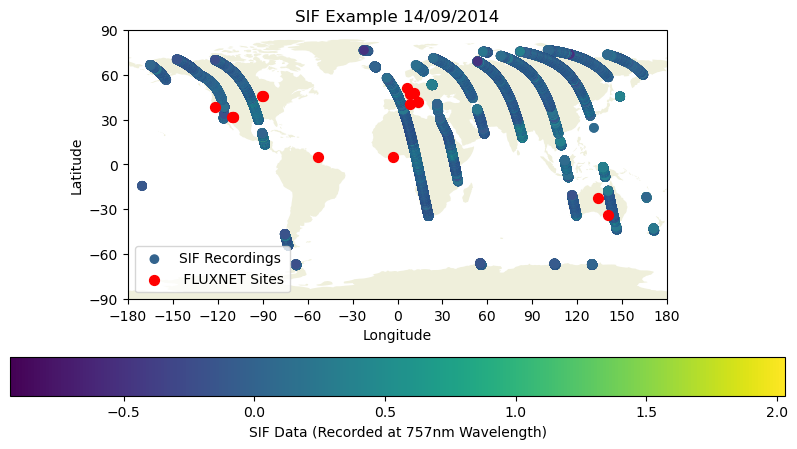

In [16]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

# Add natural earth features
ax.add_feature(cfeature.LAND) 

# Define a colormap and a normalization based on the entire dataset
global_min = np.min(sif_757nm)
global_max = np.max(sif_757nm)
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

sc = ax.scatter(sif_long_list, sif_lat_list, c=sif_757nm_list, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), label='SIF Recordings')

# FLUXNET Sites
ax.scatter(centres_long, centres_lat, color='red', s=50, transform=ccrs.PlateCarree(), label=' FLUXNET Sites')

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label='Recorded SIF (757nm)')
cbar.set_label('SIF Data (Recorded at 757nm Wavelength)', rotation=0)

ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
ax.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('SIF Example 14/09/2014')

ax.legend()
plt.show()